# Выбор таргета

IS_SELLER - наш кандидат на таргет. Возможно именно факт победы в аукционе можно считать истинным отражением релевантности поставщика заказчику.
Построив рекомендательную систему на основе такого таргета, мы будем рекомендовать заказчику тех поставщиков, которые с наибольшей вероятностью выиграют в аукционе.

В идеале я хочу рекомендовать:
1. Наиболее подходящих по области к запросу. Тех, кто исполнял похожие заказы (нужна матрица заказ-поставщик, но в отрыве от поставщика она ничего не дает, у нас в датасете сто тысяч уже законченных запросов, рекоммендовать к ним что-либо бессмысленно, а для новых возникает проблема холодного старта). Лучше использовать запрос в качестве фичей для контеного метода.
2. Наиболее честных и наименее рискованных. Можно поизвлекать признаки из аггрегаций по флагам в трейне.
3. Предлагающих наилучшие условия по деньгам. (Мы можем, например, кластеризовать заказы по описаниям или объемам, и для каждого кластера насчитать средние по финальным и начальным ценам. Определяя кластер заказа в запросе, мы можем понять, какое значение фичи подтянуть)
4. Тех, кто при всем этом действительно выиграет аукцион.

Я могу построить три рекомендательных системы: на цену, на безопасность и на победу в аукционе
А их скоры выдавать с весами, которые задает пользователь сам.

# Обучение модели

## Подрузка данных

In [1]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import rectools

from sklearn.model_selection import train_test_split

In [2]:
data_path = pathlib.Path("../data/")

offers = pd.read_csv(data_path / "d_offer.csv")
lots = pd.read_csv(data_path / "d_lot.csv")
lots_prods = pd.read_csv(data_path / "d_lot_prod.csv")
persons = pd.read_csv(data_path / "d_person.csv")

df_train = pd.read_csv(data_path / "all_ids_train.csv")

In [3]:
persons["FINAL_PARENT_OKATO_NAME"].value_counts()["Ярославская область"]

277

In [4]:
def get_merged_data(df):
    merged_df = pd.merge(df, offers, left_on=["OFFER_ID", "LOT_ID"], right_on=["OFFER_ID", "LOT_ID"], how="left") # джойним к логам офферы
    merged_df = pd.merge(merged_df, persons, left_on="OFFER_PERSON_ID", right_on="PERSON_ID", how="left").drop("PERSON_ID", axis=1)
    merged_df = pd.merge(merged_df, persons, left_on="BUYER_PERSON_ID", right_on="PERSON_ID", suffixes=("_OFFER", "_BUYER")).drop("PERSON_ID", axis=1) # джойним к поставщикам и заказчикам их города
    
    merged_df = pd.merge(merged_df, lots, on="LOT_ID", how="left") # джойним лоты
    # merged_df = pd.merge(merged_df, lots_prods, on="LOT_ID", how="left") # джойним продукты в лотах, там целый список с количествами
    return merged_df

merged_df = get_merged_data(df_train)

In [5]:
merged_df["OFFER_PERSON_ID"].value_counts().index[0]

21358

Отфильтруем странные контракты с установленными флагами

In [6]:
pd.merge(merged_df["BUYER_PERSON_ID"], persons, left_on="BUYER_PERSON_ID", right_on="PERSON_ID").drop(
            ["BUYER_PERSON_ID"], axis=1).drop_duplicates(subset=["PERSON_ID"], keep="first")

,PERSON_ID,FINAL_PARENT_OKATO_NAME
0,954,Владимирская область
5,374,Хабаровский край
19,516,Самарская область
26,736,Алтайский край
31,497,Республика Карелия
...,...,...
539894,2152,Карачаево-Черкесская Республика
540010,2947,Калининградская область
540016,24802,Свердловская область
540031,11281,Республика Татарстан


In [7]:
from functools import reduce

flags_list = ["CANCELLED_FLAG", "INCONSISTENT_FLAG", "UNCONSIDERED_FLAG", "REJECT_FLAG", "CUSTOMER_REFUSAL_FLAG"]

any_flag_filter = reduce(lambda x, y : x | y, map(lambda f: merged_df[f] == 1, flags_list))

merged_df = merged_df[~merged_df["IS_SELLER"] | ~any_flag_filter]

Посмотрим на распределение таргета

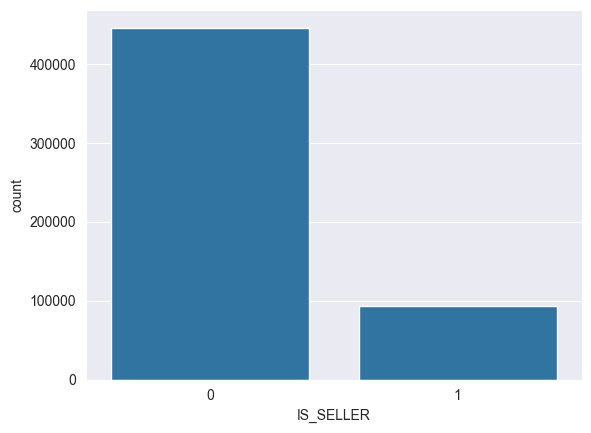

In [8]:
sns.barplot(merged_df["IS_SELLER"].value_counts())
plt.show()

Для коллаборативной фильтрации достаточно иметь только матрицу: Заказчик - поставщик - факт заключения контракта

## 1. Таргет - факт заключения контракта

### Подготовим данные

Мы проставим 1, если поставщик выиграл у заказчика хотя бы один лот


In [9]:
from rectools import Columns

base_columns = ["OFFER_PERSON_ID","BUYER_PERSON_ID", "IS_SELLER"]

df_all = merged_df[base_columns]
df_all = df_all[df_all["OFFER_PERSON_ID"] != -1]
df_all = df_all.rename(columns={
    "BUYER_PERSON_ID": Columns.User,
    "OFFER_PERSON_ID": Columns.Item,
    "IS_SELLER": Columns.Weight
})
df_all[Columns.Datetime] = -1

df = df_all.groupby([Columns.User, Columns.Item]).max().reset_index()
df.head()

,user_id,item_id,weight,datetime
0,8,12,1,-1
1,8,214,0,-1
2,8,725,1,-1
3,8,762,0,-1
4,8,918,0,-1


Посмотрим на распределение числа интеракиций заказчиков

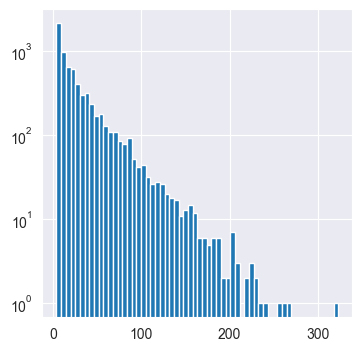

In [10]:
interactions_count = df.groupby(Columns.User)[Columns.Item].count()

fig, ax = plt.subplots(figsize=(4,4))
plt.hist(interactions_count, bins=60, log=True)
plt.show()

In [11]:
interactions_count.describe()

count    7035.000000
mean       29.491542
std        32.743418
min         4.000000
25%         7.000000
50%        17.000000
75%        39.000000
max       323.000000
Name: item_id, dtype: float64

Видим, что есть заказчики с большим числом интеракций с разными поставщиками, но при этом подавляющее большинство среди них взаимодействовало с совсем небольшим количеством поставщиков.

Оценим распределение на общее число интеракций, а не только с уникальными поставщиками.

[]

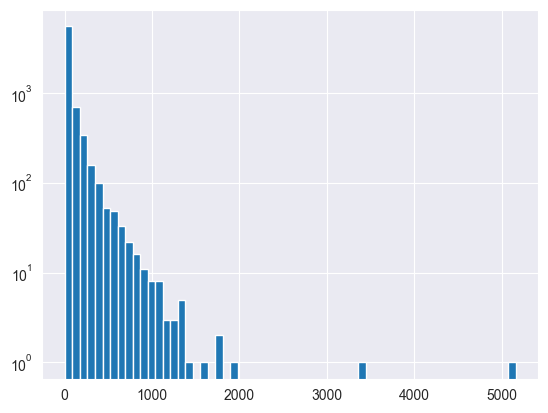

In [12]:
interactions_count_all = df_all.groupby(Columns.User)[Columns.Item].count()

plt.hist(interactions_count_all, bins=60, log=True)
plt.plot()

In [13]:
interactions_count_all.describe()

count    7035.000000
mean       76.756930
std       160.121899
min         4.000000
25%         8.500000
50%        24.000000
75%        75.000000
max      5160.000000
Name: item_id, dtype: float64

На общее число интеракций у нас вообще гигантский разброс.
Кажется, это связано с тем, что на рынке есть игроки совершенно разного масштаба: крупные компании делают заказы постоянно.

Определим холодных юзеров. Мы сможем сделать по ним срез данных.
С учетом квантиля в 25% на 8.5 будем считать юзера холодным, если у него <= 8 интеракций

In [14]:
cold_user_threshold = 8
df_all = pd.merge(df_all, interactions_count_all <= cold_user_threshold, left_on=Columns.User, right_on=Columns.User, how="left").rename(columns={Columns.Item + "_y": "is_cold", Columns.Item + "_x": Columns.Item})

cold_user_threshold_unique = 6
df = pd.merge(df, interactions_count <= cold_user_threshold_unique, left_on=Columns.User, right_on=Columns.User, how="left").rename(columns={Columns.Item + "_y": "is_cold", Columns.Item + "_x": Columns.Item})

Мы избавляемся от повторений интеракций.

In [15]:
df_train, df_test = train_test_split(df, train_size=0.8, random_state=72) 

df_test = df_test[df_test[Columns.User].isin(df_train[Columns.User])]

### Модель Popular

Будем считать поставщика популярным, если к нему обращаются много разных заказчиков.

In [16]:
from rectools.models import PopularModel
from rectools.dataset import Dataset

model = PopularModel(
    popularity="n_users", # mean_weight, sum_weight, n_interactions
    verbose=1
)
# количество взаимодействий не равно количеству пользователей, так что один юзер мог взаимодействовать несколько раз с разными эффектами
model.fit(Dataset.construct(df_train))

#### Оценка качества

Метрики ранжирования:
1. Precision@k, MeanAveragePrecision, nDCG

Метрики рекомендаций:
1. ILS (Diversity), Serendipity

К сожалению, в рамках курсача невозможно оценить бизнес-метрики

##### 1. Метрики ранжирования

In [17]:
recs = model.recommend(
    users=df_train[Columns.User].unique(),
    dataset=Dataset.construct(df_train),
    k=10,
    filter_viewed=False
)
recs

  0%|          | 0/7035 [00:00<?, ?it/s]

,user_id,item_id,score,rank
0,836,21358,1902.0,1
1,836,1310,1727.0,2
2,836,5284,1611.0,3
3,836,1112,1185.0,4
4,836,1413,1123.0,5
...,...,...,...,...
70345,900,21370,1031.0,6
70346,900,1575,968.0,7
70347,900,3872,931.0,8
70348,900,1612,926.0,9


In [18]:
df_train[Columns.User][0]

8

In [19]:
model.recommend(
    users=[df_train[Columns.User][0]],
    dataset=Dataset.construct(df_train),
    k=10,
    filter_viewed=True
)

  0%|          | 0/1 [00:00<?, ?it/s]

,user_id,item_id,score,rank
0,8,21358,1902.0,1
1,8,1310,1727.0,2
2,8,21370,1031.0,3
3,8,1575,968.0,4
4,8,1612,926.0,5
5,8,3550,895.0,6
6,8,1093,879.0,7
7,8,3792,817.0,8
8,8,5565,766.0,9
9,8,11666,657.0,10


In [20]:
def score(metric, recs, df):
    cold_users = df[Columns.User][df["is_cold"]]
    cold_users_filter = recs[Columns.User].isin(cold_users)
    
    res = {}
    res["cold"] = metric.calc(recs[cold_users_filter], df[df["is_cold"]])
    res["hot"] = metric.calc(recs[~cold_users_filter], df[~df["is_cold"]])
    res["all"] = metric.calc(recs, df)
    return res

Установим k=1000, и теперь вручную переберем тип нашей рекомендательной системы:

In [21]:
for model_type in ["n_users", "n_interactions"]:
    k=1000
    
    model = PopularModel(
        popularity=model_type,
        verbose=False
    )
    model.fit(Dataset.construct(df_train))
    recs = model.recommend(
        users=df_test[Columns.User].unique(),
        dataset=Dataset.construct(df_test),
        k=k,
        filter_viewed=True
    )
    scores = pd.DataFrame([
        score(MAP(k=k), recs, df_test),
        score(NDCG(k=k), recs, df_test)
    ], index=["MAP", "NDCG"])
    print(f"{model_type}:")
    print(scores)

NameError: name 'MAP' is not defined

##### 2. Метрики рекомендаций

In [ ]:
from rectools.metrics import calc_metrics, Recall, Precision
from rectools.metrics.novelty import NoveltyMetric
from rectools.metrics.serendipity import SerendipityMetric

In [ ]:
df_train[Columns.User].nunique(), df_test[Columns.User].nunique()

In [ ]:
def calc_metrics_(candidates_df, train_interactions, test_interactions, rank_col: str, k: int):
    """
    :param candidates_df: набор предсказаний на трейне вместе с рангами для всех моделей в сравнении сразу (поджойненный)
    :param train_interactions: датасет интеракций до показа рекомендаций
    :param test_interactions: датасет интеракций после показа рекомендаций
    :param rank_col: колонка с рангом в зависимости от модели
    :param k: число рекомендаций
    :return: 
    """
    metrics = {
        f"ndcg@{k}": NDCG(k=k),
        f"map@{k}": MAP(k=k),
        f"precision@{k}": Precision(k=k),
        f"recall@{k}": Recall(k=k),
        f"novelty@{k}": NoveltyMetric(k=k),
        f"serendipity@{k}": SerendipityMetric(k=k),
    }
    
    test_users = test_interactions[Columns.User].unique()
    items = pd.concat([test_interactions[Columns.Item], train_interactions[Columns.Item]]).unique()
    
    return calc_metrics(
        metrics=metrics,
        reco=(
            candidates_df.rename(columns={rank_col: Columns.Rank})[
                [Columns.User, Columns.Item, Columns.Rank]
            ][candidates_df[Columns.User].isin(test_users)]
        ),
        interactions=(
            test_interactions[[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]][
                test_interactions[Columns.User].isin(test_users)
            ]
        ),
        prev_interactions=(
            train_interactions[
                [Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]
            ][train_interactions[Columns.User].isin(test_users)]
        ),
        catalog=items,
    )

calc_metrics_(recs, df_train, df_test, "rank", 10)

Таковы наши метрики для модели популярных)

### ALS

Создадим модель для Implicit ALS

In [ ]:
from rectools.models import ImplicitALSWrapperModel
from implicit.als import AlternatingLeastSquares

os.environ["OPENBLAS_NUM_THREADS"] = "1"
base_model = AlternatingLeastSquares(
    factors=100,
    regularization=0.01,
    alpha=1.0,
    calculate_training_loss=True
)
implicit_als_model = ImplicitALSWrapperModel(base_model, verbose=1)

В данных в колонке Weight я передаю сырые взаимодействия Rui.
Pui рассчитывается автоматически: 
- Pui = 1, если Rui > 0
- Pui = 0 иначе

Далее Cui = 1 + alpha * Pui

In [ ]:
implicit_als_model.fit(
    Dataset.construct(df_train)
)

In [ ]:
als_recs = implicit_als_model.recommend(
    users=df_train[Columns.User].unique(),
    dataset=Dataset.construct(df_train),
    k=10,
    filter_viewed=True
)

In [ ]:
result_metrics = {}
result_metrics["top_pop"] = calc_metrics_(
    recs,
    df_train, 
    df_test, 
    Columns.Rank,
    10
)
result_metrics["als"] = calc_metrics_(
    als_recs,
    df_train, 
    df_test, 
    Columns.Rank,
    10
)
pd.DataFrame(result_metrics)

По сводной таблице видим, что ALS значительно прокачал нашу модель. 
Остановимся пока на этом и выкатим код ALS в прод.